TKO_3120 Machine Learning and Pattern Recognition

exercise <br>
Marita Risku <br> 
mhrisk@utu.fi <br>
18.2.2019

# Image recognition of color images

##  1. Introduction

This is an image recognition task of color images. There is one object to be recognized in each image. Therefore each image is given one glass. Different classifiers will be used to train classifiers to identify the class of an image:
* kNN
* Regularized linear model
* Multi-layer perceptron MLP

After training, the performance of each classifier will be estimated. 


## 2. Data set

The data is from image-net.org. URLs of images are stored as textfiles. 

Three sets of image URLs was provided in Moodle:
* Bird nests, 39 pictures
* Lighthouses, 42 pictures
* Honeycombs, 39 pictures

As a fourth image set, I will use 
* Strawberries, 39 pictures


## 3. Methods

In this exercise, I will use following methods.

To reduce the quantization level:
* kMeans (K-means clustering) assign each data point to the cluster that has nearest mean. 

To compute second order texture measures:
* GLCM (Gray-Level Co-Occurence matrix) computes relationships between neighboring pixels. With GLCM I will measure contrast, homogeneity, angular second moment (ASM) and correlation. 

To illustrate feature relationships:
* PCA (Principal component analysis) use an orthogonal transformation to compute the principal components of possibly linearly correlated features. By using only two first principal compotents, it is possible to construct a projection to two-dimensional space in order to visualize the relationships.
* SOM (Self Organizing Maps) can capture also nonlinear correlations between features and do the projection into two-dimensional space. 

Classifiers:
* kNN (k Nearest Neighbors Classifier) does classification by choosing the majority class among the k nearest neighbors. I will use as number of neighbours (k) values from 1 to 20. 
* Regularized linear model with ridge regression. It's objective function has two parts: a goodness-of-fit term and a reqularization term that penalizes too complex models. As a goodness-of-fit term the least squares error is used. And as a regularization term W.T*W (alpha = 1.0)
* MLP (Multi-layer perceptron) with one hidden layer and early stop committee. Softmax is used as a output function.

Estimating the accuracy of a classification method:
* Nested leave-one-out and stratified K-Folds cross-validation are used in order to utilize the data as efficiently as possible to training, validation and testing. An inner loop is used for optimizating the hyper parameters (training and validation) and the outer loop is used for testing.


In [410]:
# libaries used in this task
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops

from minisom import MiniSom  
from pylab import plot,axis,show,pcolor,colorbar,bone

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge

from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


## 4. Data preparation

### 4.1 Read in the data

In [27]:
# I have added these downloads in order to avoid running the whole notebook when continuing after longer break.
# download features
X = np.load('X.npy')
# download labels
y = np.load('y.npy')
# download color images 300 x 300
X_color = np.load('X_color.npy')
# download 8-level gray images 300 x 300
X_gray_8 = np.load('X_gray_8.npy')

In [2]:
#read in the data of bird nests
urls = np.loadtxt('birdnests.txt', dtype='U100')
birdnests= []
for i in range(len(urls)):
    url = urls[i]
    img = io.imread(url)
    birdnests.append(img)

39

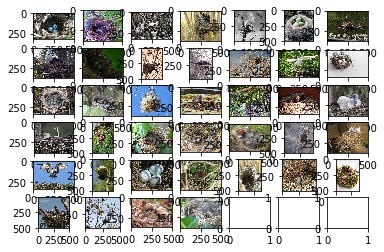

In [3]:
# show the original pictures of bird nests
io.imshow_collection(birdnests)
len(birdnests)

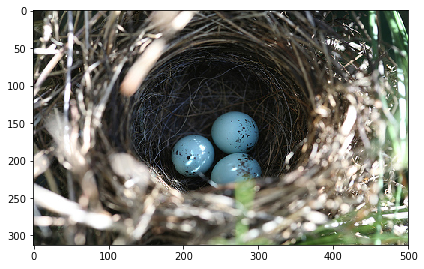

In [4]:
# show the first picture of bird nests
io.imshow(birdnests[0])

In [5]:
#read in the data of light houses
urls = np.loadtxt('lighthouse.txt', dtype='U100')
lighthouses= []
for i in range(len(urls)):
    url = urls[i]
    img = io.imread(url)
    lighthouses.append(img)   

42

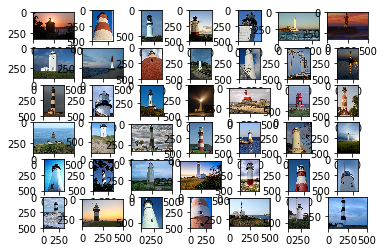

In [6]:
io.imshow_collection(lighthouses)
len(lighthouses)

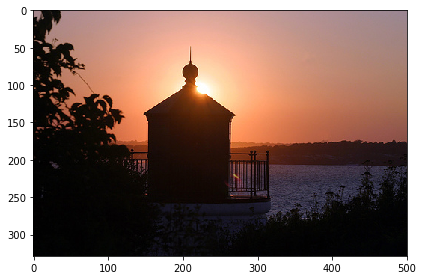

In [7]:
io.imshow(lighthouses[0])

In [8]:
#read in the data of honeycombs
urls = np.loadtxt('honeycomb.txt', dtype='U100')
honeycombs= []
for i in range(len(urls)):
    url = urls[i]
    img = io.imread(url)
    honeycombs.append(img)

39

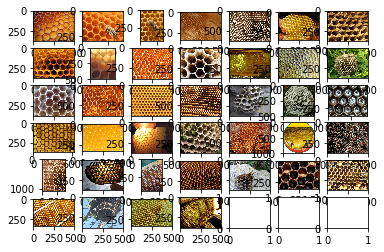

In [9]:
io.imshow_collection(honeycombs)
len(honeycombs)

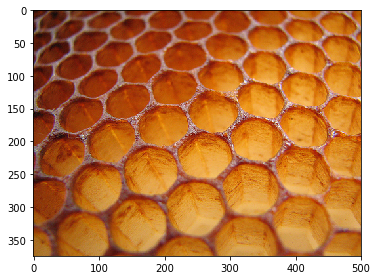

In [10]:
io.imshow(honeycombs[0])

In [11]:
#read in the data of strawberries
urls = np.loadtxt('strawberry.txt', dtype='U100')
strawberries= []
for i in range(len(urls)):
    url = urls[i]
    try:
        img = io.imread(url)
        strawberries.append(img)
    except:
        print('problem ', i, url)

39

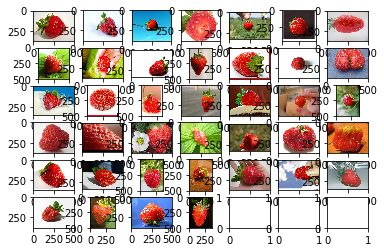

In [12]:
io.imshow_collection(strawberries)
len(strawberries)

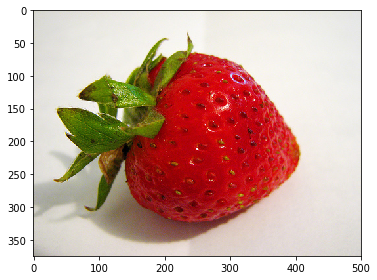

In [13]:
io.imshow(strawberries[0])

### 4.2 Crop the images into the same size

In [14]:
# check the picture sizes
for i in range(len(birdnests)):
    print(i, lighthouses[i].shape, '   ', birdnests[i].shape,'   ', honeycombs[i].shape,'   ', strawberries[i].shape)

0 (329, 500, 3)     (313, 500, 3)     (375, 500, 3)     (375, 500, 3)
1 (500, 332, 3)     (398, 500, 3)     (300, 400, 3)     (400, 500, 3)
2 (600, 400, 3)     (332, 500, 3)     (450, 338, 3)     (396, 500, 3)
3 (500, 360, 3)     (375, 500, 3)     (338, 500, 3)     (400, 500, 3)
4 (500, 375, 3)     (490, 500, 3)     (768, 1024, 3)     (333, 500, 3)
5 (400, 600, 3)     (500, 473, 3)     (334, 500, 3)     (458, 500, 3)
6 (333, 500, 3)     (375, 500, 3)     (375, 500, 3)     (375, 500, 3)
7 (375, 500, 3)     (375, 500, 3)     (375, 500, 3)     (500, 500, 3)
8 (375, 500, 3)     (375, 500, 3)     (500, 399, 3)     (375, 500, 3)
9 (500, 334, 3)     (500, 349, 3)     (390, 500, 3)     (333, 500, 3)
10 (500, 333, 3)     (440, 330, 3)     (375, 500, 3)     (500, 375, 3)
11 (500, 333, 3)     (333, 500, 3)     (374, 500, 3)     (379, 500, 3)
12 (500, 374, 3)     (333, 500, 3)     (374, 500, 3)     (375, 500, 3)
13 (500, 333, 3)     (333, 500, 3)     (375, 500, 3)     (375, 500, 3)
14 (500, 333, 3

The lenght of the shortest side seems to be 300. Hence I will crob an area of 300 x 300 pixels from the center of each image.

In [15]:
# function that crobs 300 x 300 pixels from the center of each image and returns crobbed pictures in tensor
def crob(imagelist):
    imagelist_crobbed = np.zeros((len(imagelist), 300,300, 3), dtype = np.uint8)
    for i in range(len(imagelist)):
        im = imagelist[i]
        x = im.shape[0]
        y = im.shape[1]
        x_1 = x // 2 - 150 
        x_2 = x_1 + 300
        y_1 = y // 2 - 150
        y_2 = y_1 + 300
        im_crob = im[x_1 :x_2 , y_1 : y_2, :]
        imagelist_crobbed[i] = im_crob
    return imagelist_crobbed
    

In [16]:
birdnests_crobbed = crob(birdnests)
lighthouses_crobbed = crob(lighthouses)
honeycombs_crobbed = crob(honeycombs)
strawberries_crobbed = crob(strawberries)

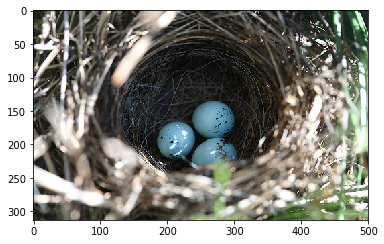

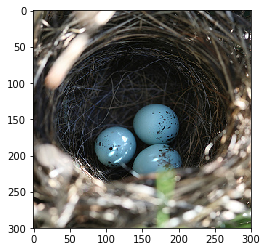

In [17]:
im1 = birdnests[0]
im2 = birdnests_crobbed[0]
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()

### 4.3 Store the data of colorimages
Next I will store the data of colorimages in one tensor (X_color) and the labels in one vector (y).

In [74]:
X_color = np.concatenate((birdnests_crobbed, lighthouses_crobbed, honeycombs_crobbed, strawberries_crobbed), axis = 0)

# save colorimages
np.save('X_color.npy', X_color)

(159, 300, 300, 3)

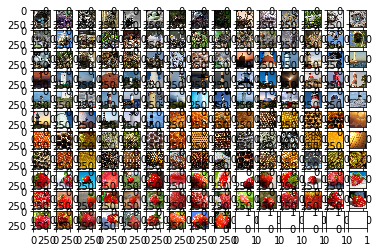

In [19]:
io.imshow_collection(X_color)
X_color.shape

In [76]:
y = np.empty(159, dtype=np.uint8)
for i in range(39):
    y[i] = 0
for i in range(39, 81):
    y[i] = 1
for i in range(81, 120):
    y[i]= 2
for i in range(120, 159):
    y[i]= 3
# save labels
np.save('y.npy', y)
y.shape

(159,)

### 4.4 Store the data of grayscale images
For GLCM I need to change the images into grayscale and reduce the quantization level to 8 levels.

In [90]:
X_gray = np.zeros((159,300,300),dtype=np.float32)
for i in range(0,159):
    img = rgb2gray(X_color[i])
    X_gray[i] = np.array(img)

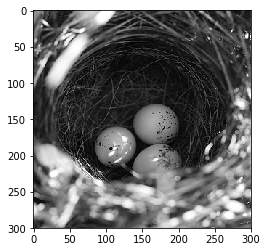

[[0.1730698  0.34337178 0.5534698  ... 0.10734941 0.11151608 0.16725138]
 [0.31260234 0.55349255 0.54030627 ... 0.09022667 0.1031302  0.17229687]
 [0.49490628 0.46967256 0.5128098  ... 0.10286235 0.10286235 0.16755687]
 ...
 [0.2380102  0.24223725 0.19406942 ... 0.46533215 0.4468553  0.4446153 ]
 [0.22400549 0.22906588 0.20191255 ... 0.4538651  0.43901217 0.42610863]
 [0.22400549 0.23298745 0.19601883 ... 0.4303357  0.41548276 0.40371802]]


In [91]:
plt.imshow(X_gray[0], cmap=plt.cm.gray)
plt.show()
print(X_gray[0])



I use kMeans from scikit-learn library to reduce the quantization level to 8 levels.

In [75]:
kmeans=KMeans(n_clusters=8)
X_gray_8 = np.zeros((159,300 * 300),dtype=np.uint8)
X_gray_as_rows = X_gray.reshape(159,300*300,1)
for i in range(0,159):
    img = kmeans.fit_predict(X_gray_as_rows[i])
    X_gray_8[i] = np.array(img, dtype=np.uint8)

X_gray_8 = X_gray_8.reshape(159,300,300)
# save 8-level gray images:
np.save('X_gray_8.npy', X_gray_8)

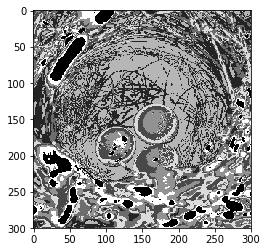

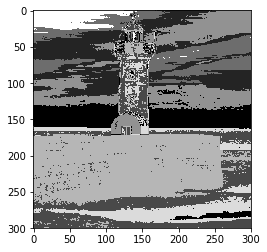

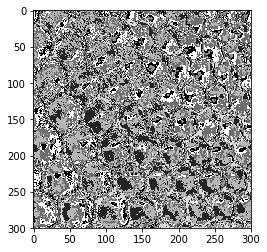

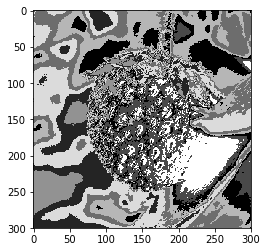

array([[1, 6, 2, ..., 5, 5, 1],
       [3, 2, 2, ..., 5, 5, 1],
       [2, 2, 2, ..., 5, 5, 1],
       ...,
       [3, 3, 1, ..., 2, 2, 2],
       [3, 3, 1, ..., 2, 6, 6],
       [3, 3, 1, ..., 6, 6, 6]], dtype=uint8)

In [25]:
plt.imshow(X_gray_8[0], cmap=plt.cm.gray)
plt.show()

plt.imshow(X_gray_8[45], cmap=plt.cm.gray)
plt.show()

plt.imshow(X_gray_8[90], cmap=plt.cm.gray)
plt.show()

plt.imshow(X_gray_8[140], cmap=plt.cm.gray)
plt.show()

X_gray_8[0]



### 4.5 Feature extraction
Each image has 300*300 pixels. Thus the vector of all pixels would be of size 90 000.  Pixels are not well suitable for classification either do to large degree of correlation. Instead I will choose 12 features, which I will use to train the classification methods.


#### 4.5.1 Features extracted from color images: first order texture measures (statistics)
1. average redness
2. average greenness
3. average bluness
4. variance of redness
5. variance of greenness
6. variance of bluness

In [4]:
# function that calculates averages and variances of colors from one picture
def colors(image):
    red_m= np.mean(image[:,:,0])
    green_m= np.mean(image[:,:,1])
    blue_m= np.mean(image[:,:,2])
    red_v= np.var(image[:,:,0])
    green_v= np.var(image[:,:,1])
    blue_v= np.var(image[:,:,2])
    x = [red_m, green_m, blue_m, red_v, green_v, blue_v]
    return x

In [5]:
# creating color features:
X_c = np.zeros((159,6),dtype=np.float64)
for i in range(159):
    X_c[i] = colors(X_color[i])


In [6]:
# checking what I have so far:
X_c_df = pd.DataFrame(data = X_c, columns = ['average red', 'average green', 'average blue', 
                                         'variance red', 'variance green', 'varriance blue'])
X_c_df.describe()

average red  average green  average blue  variance red  variance green  \
count   159.000000     159.000000    159.000000    159.000000      159.000000   
mean    138.417384     114.152976     97.240803   3412.994545     3847.299321   
std      40.375238      31.763807     47.545124   1797.584146     1842.203393   
min      26.784611      35.753067     10.775944     46.837511      310.185170   
25%     113.353122      92.482417     61.988317   2163.368352     2557.736231   
50%     134.024022     113.254833     91.139333   3311.567922     3524.312132   
75%     166.186361     135.988200    137.492139   4434.586702     4837.418024   
max     248.355622     195.985067    220.863111   9940.838305    11254.781990   

       varriance blue  
count      159.000000  
mean      3983.481284  
std       2323.688428  
min        153.451842  
25%       2403.590685  
50%       3641.351540  
75%       5499.620238  
max      11280.476130

In [9]:
# z-score standardization:
X_c = zscore(X_c, axis=0)

In [8]:
# The color features after standardization:
X_df = pd.DataFrame(data = X_c, columns = ['average red', 'average green', 'average blue', 
                                         'variance red', 'variance green', 'varriance blue'])
X_df.describe()

average red  average green  average blue  variance red  \
count  1.590000e+02   1.590000e+02  1.590000e+02  1.590000e+02   
mean   3.575058e-16   1.977454e-15  4.245381e-16 -4.915704e-16   
std    1.003160e+00   1.003160e+00  1.003160e+00  1.003160e+00   
min   -2.773618e+00  -2.476014e+00 -1.824331e+00 -1.878517e+00   
25%   -6.227444e-01  -6.843962e-01 -7.437959e-01 -6.973662e-01   
50%   -1.091571e-01  -2.836499e-02 -1.287355e-01 -5.660213e-02   
75%    6.899455e-01   6.895966e-01  8.492672e-01  5.701096e-01   
max    2.731516e+00   2.584408e+00  2.608320e+00  3.642928e+00   

       variance green  varriance blue  
count    1.590000e+02    1.590000e+02  
mean    -6.479792e-16   -3.924185e-16  
std      1.003160e+00    1.003160e+00  
min     -1.926112e+00   -1.653462e+00  
25%     -7.022230e-01   -6.820546e-01  
50%     -1.758805e-01   -1.477008e-01  
75%      5.391625e-01    6.545324e-01  
max      4.033695e+00    3.150186e+00

I plot six scatter plots of these six features to visualize the relation between these features and the four labels.

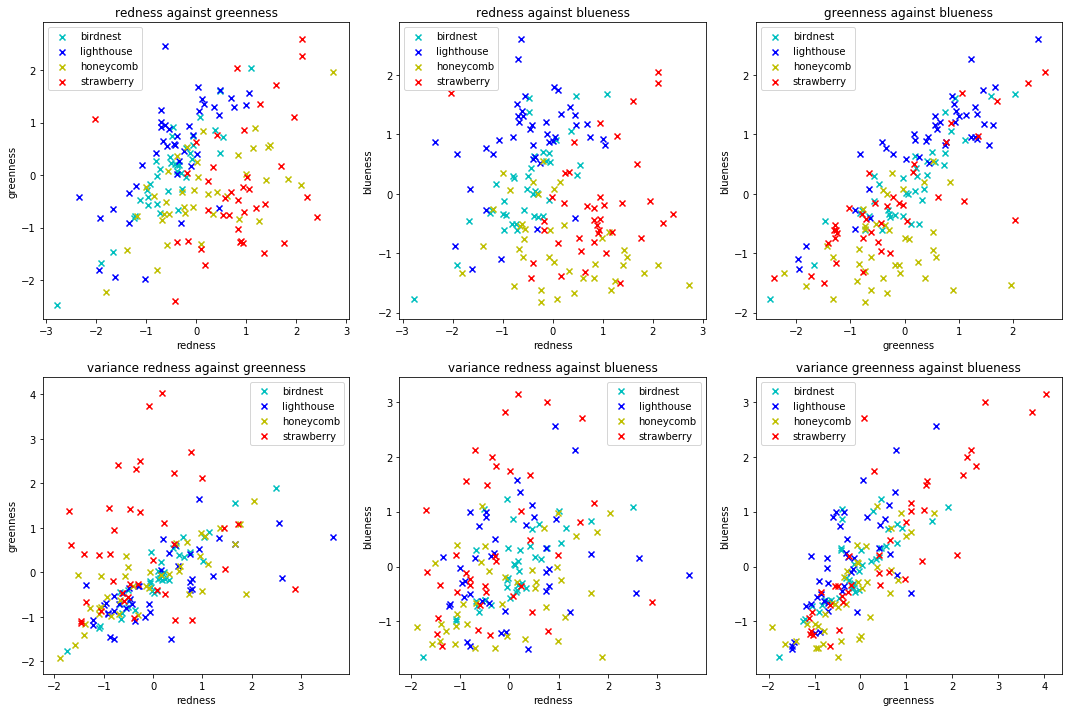

In [31]:
ind_1 = np.where(y == 0)
ind_2 = np.where(y == 1)
ind_3 = np.where(y == 2)
ind_4 = np.where(y == 3)

X = X_c
# Set figure size (width, height)
fig, axes = plt.subplots(2, 3,figsize=(15, 10))
# redness against greenness
axes[0,0].scatter(X[ind_1,0],X[ind_1,1], c='c', marker ='x', label='birdnest')
axes[0,0].scatter(X[ind_2,0],X[ind_2,1], c='b', marker ='x', label='lighthouse')
axes[0,0].scatter(X[ind_3,0],X[ind_3,1], c='y', marker ='x', label='honeycomb')
axes[0,0].scatter(X[ind_4,0],X[ind_4,1], c='r', marker ='x', label='strawberry')
axes[0,0].set_xlabel('redness')
axes[0,0].set_ylabel('greenness')
axes[0,0].legend()
axes[0,0].set_title('redness against greenness')

# redness against blueness
axes[0,1].scatter(X[ind_1,0],X[ind_1,2], c='c', marker ='x', label='birdnest')
axes[0,1].scatter(X[ind_2,0],X[ind_2,2], c='b', marker ='x', label='lighthouse')
axes[0,1].scatter(X[ind_3,0],X[ind_3,2], c='y', marker ='x', label='honeycomb')
axes[0,1].scatter(X[ind_4,0],X[ind_4,2], c='r', marker ='x', label='strawberry')
axes[0,1].set_xlabel('redness')
axes[0,1].set_ylabel('blueness')
axes[0,1].legend()
axes[0,1].set_title('redness against blueness')
                  
# greenness against blueness
axes[0,2].scatter(X[ind_1,1],X[ind_1,2], c='c', marker ='x', label='birdnest')
axes[0,2].scatter(X[ind_2,1],X[ind_2,2], c='b', marker ='x', label='lighthouse')
axes[0,2].scatter(X[ind_3,1],X[ind_3,2], c='y', marker ='x', label='honeycomb')
axes[0,2].scatter(X[ind_4,1],X[ind_4,2], c='r', marker ='x', label='strawberry')
axes[0,2].set_xlabel('greenness')
axes[0,2].set_ylabel('blueness')
axes[0,2].legend()
axes[0,2].set_title('greenness against blueness')

# variance: redness against greenness
axes[1,0].scatter(X[ind_1,3],X[ind_1,4], c='c', marker ='x', label='birdnest')
axes[1,0].scatter(X[ind_2,3],X[ind_2,4], c='b', marker ='x', label='lighthouse')
axes[1,0].scatter(X[ind_3,3],X[ind_3,4], c='y', marker ='x', label='honeycomb')
axes[1,0].scatter(X[ind_4,3],X[ind_4,4], c='r', marker ='x', label='strawberry')
axes[1,0].set_xlabel('redness')
axes[1,0].set_ylabel('greenness')
axes[1,0].legend()
axes[1,0].set_title('variance redness against greenness')

# variance: redness against blueness
axes[1,1].scatter(X[ind_1,3],X[ind_1,5], c='c', marker ='x', label='birdnest')
axes[1,1].scatter(X[ind_2,3],X[ind_2,5], c='b', marker ='x', label='lighthouse')
axes[1,1].scatter(X[ind_3,3],X[ind_3,5], c='y', marker ='x', label='honeycomb')
axes[1,1].scatter(X[ind_4,3],X[ind_4,5], c='r', marker ='x', label='strawberry')
axes[1,1].set_xlabel('redness')
axes[1,1].set_ylabel('blueness')
axes[1,1].legend()
axes[1,1].set_title('variance redness against blueness')
                  
# variance: greenness against blueness
axes[1,2].scatter(X[ind_1,4],X[ind_1,5], c='c', marker ='x', label='birdnest')
axes[1,2].scatter(X[ind_2,4],X[ind_2,5], c='b', marker ='x', label='lighthouse')
axes[1,2].scatter(X[ind_3,4],X[ind_3,5], c='y', marker ='x', label='honeycomb')
axes[1,2].scatter(X[ind_4,4],X[ind_4,5], c='r', marker ='x', label='strawberry')
axes[1,2].set_xlabel('greenness')
axes[1,2].set_ylabel('blueness')
axes[1,2].legend()
axes[1,2].set_title('variance greenness against blueness')

plt.tight_layout()

plt.show()

#### 4.5.2 Features extracted from gray images quantizated to 8 levels: Second order texture measures (relationship among neighboring pixels)

Features derived from Gray-Level Co-Occurrence matrix (GLCM):
* Homogeneity
* Angular Second Moment (smoothness)
* Correlation
* Contrast

I will use greycomatrix and greycoprops from scikit-image to calculate GLCM and the features. 

I will first calculate features with distances of 5 and angles [0, 45, 90]. This will yield to 1x3x3 = 9 features.

In [32]:
# function that calculates features from GLCM: 
def gray1(image):
    glcm = greycomatrix(image, [5], [0, 45, 90], symmetric=True, normed=True)
    homogeneity = greycoprops(glcm, 'homogeneity')
    AngularSecondMoment = greycoprops(glcm, 'ASM')
    correlation = greycoprops(glcm, 'correlation')
    x=[homogeneity, AngularSecondMoment, correlation]
    return np.array(x).reshape(9)
    

In [33]:
# creating features from GLCM:
X_glcm1 = np.zeros((159,9),dtype=np.float64)
for i in range(159):
    X_glcm1[i] = gray1(X_gray_8[i])

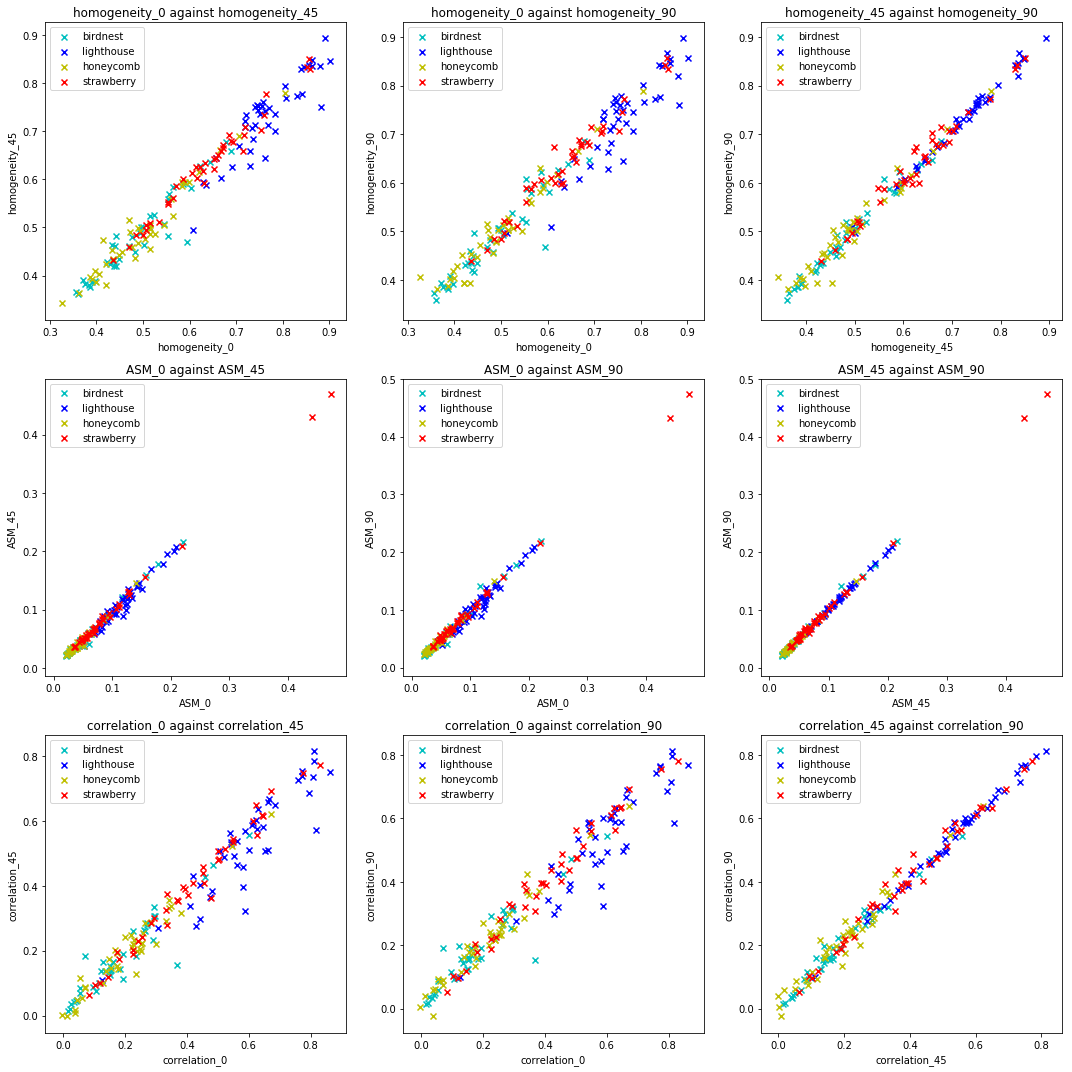

In [34]:
ind_1 = np.where(y == 0)
ind_2 = np.where(y == 1)
ind_3 = np.where(y == 2)
ind_4 = np.where(y == 3)

X = X_glcm1
# Set figure size (width, height)
fig, axes = plt.subplots(3, 3,figsize=(15, 15))
# homogeneity_0 against homogeneity_45
axes[0,0].scatter(X[ind_1,0],X[ind_1,1], c='c', marker ='x', label='birdnest')
axes[0,0].scatter(X[ind_2,0],X[ind_2,1], c='b', marker ='x', label='lighthouse')
axes[0,0].scatter(X[ind_3,0],X[ind_3,1], c='y', marker ='x', label='honeycomb')
axes[0,0].scatter(X[ind_4,0],X[ind_4,1], c='r', marker ='x', label='strawberry')
axes[0,0].set_xlabel('homogeneity_0')
axes[0,0].set_ylabel('homogeneity_45')
axes[0,0].legend()
axes[0,0].set_title('homogeneity_0 against homogeneity_45')

# homogeneity_0 against homogeneity_90
axes[0,1].scatter(X[ind_1,0],X[ind_1,2], c='c', marker ='x', label='birdnest')
axes[0,1].scatter(X[ind_2,0],X[ind_2,2], c='b', marker ='x', label='lighthouse')
axes[0,1].scatter(X[ind_3,0],X[ind_3,2], c='y', marker ='x', label='honeycomb')
axes[0,1].scatter(X[ind_4,0],X[ind_4,2], c='r', marker ='x', label='strawberry')
axes[0,1].set_xlabel('homogeneity_0')
axes[0,1].set_ylabel('homogeneity_90')
axes[0,1].legend()
axes[0,1].set_title('homogeneity_0 against homogeneity_90')
                  
# homogeneity_45 against homogeneity_90
axes[0,2].scatter(X[ind_1,1],X[ind_1,2], c='c', marker ='x', label='birdnest')
axes[0,2].scatter(X[ind_2,1],X[ind_2,2], c='b', marker ='x', label='lighthouse')
axes[0,2].scatter(X[ind_3,1],X[ind_3,2], c='y', marker ='x', label='honeycomb')
axes[0,2].scatter(X[ind_4,1],X[ind_4,2], c='r', marker ='x', label='strawberry')
axes[0,2].set_xlabel('homogeneity_45')
axes[0,2].set_ylabel('homogeneity_90')
axes[0,2].legend()
axes[0,2].set_title('homogeneity_45 against homogeneity_90')

# ASM_0 against ASM_45
axes[1,0].scatter(X[ind_1,3],X[ind_1,4], c='c', marker ='x', label='birdnest')
axes[1,0].scatter(X[ind_2,3],X[ind_2,4], c='b', marker ='x', label='lighthouse')
axes[1,0].scatter(X[ind_3,3],X[ind_3,4], c='y', marker ='x', label='honeycomb')
axes[1,0].scatter(X[ind_4,3],X[ind_4,4], c='r', marker ='x', label='strawberry')
axes[1,0].set_xlabel('ASM_0')
axes[1,0].set_ylabel('ASM_45')
axes[1,0].legend()
axes[1,0].set_title('ASM_0 against ASM_45')

# ASM_0 against ASM_90
axes[1,1].scatter(X[ind_1,3],X[ind_1,5], c='c', marker ='x', label='birdnest')
axes[1,1].scatter(X[ind_2,3],X[ind_2,5], c='b', marker ='x', label='lighthouse')
axes[1,1].scatter(X[ind_3,3],X[ind_3,5], c='y', marker ='x', label='honeycomb')
axes[1,1].scatter(X[ind_4,3],X[ind_4,5], c='r', marker ='x', label='strawberry')
axes[1,1].set_xlabel('ASM_0')
axes[1,1].set_ylabel('ASM_90')
axes[1,1].legend()
axes[1,1].set_title('ASM_0 against ASM_90')
                  
# ASM_45 against ASM_90
axes[1,2].scatter(X[ind_1,4],X[ind_1,5], c='c', marker ='x', label='birdnest')
axes[1,2].scatter(X[ind_2,4],X[ind_2,5], c='b', marker ='x', label='lighthouse')
axes[1,2].scatter(X[ind_3,4],X[ind_3,5], c='y', marker ='x', label='honeycomb')
axes[1,2].scatter(X[ind_4,4],X[ind_4,5], c='r', marker ='x', label='strawberry')
axes[1,2].set_xlabel('ASM_45')
axes[1,2].set_ylabel('ASM_90')
axes[1,2].legend()
axes[1,2].set_title('ASM_45 against ASM_90')

# correlation_0 against correlation_45
axes[2,0].scatter(X[ind_1,6],X[ind_1,7], c='c', marker ='x', label='birdnest')
axes[2,0].scatter(X[ind_2,6],X[ind_2,7], c='b', marker ='x', label='lighthouse')
axes[2,0].scatter(X[ind_3,6],X[ind_3,7], c='y', marker ='x', label='honeycomb')
axes[2,0].scatter(X[ind_4,6],X[ind_4,7], c='r', marker ='x', label='strawberry')
axes[2,0].set_xlabel('correlation_0')
axes[2,0].set_ylabel('correlation_45')
axes[2,0].legend()
axes[2,0].set_title('correlation_0 against correlation_45')

# correlation_0 against correlation_90
axes[2,1].scatter(X[ind_1,6],X[ind_1,8], c='c', marker ='x', label='birdnest')
axes[2,1].scatter(X[ind_2,6],X[ind_2,8], c='b', marker ='x', label='lighthouse')
axes[2,1].scatter(X[ind_3,6],X[ind_3,8], c='y', marker ='x', label='honeycomb')
axes[2,1].scatter(X[ind_4,6],X[ind_4,8], c='r', marker ='x', label='strawberry')
axes[2,1].set_xlabel('correlation_0')
axes[2,1].set_ylabel('correlation_90')
axes[2,1].legend()
axes[2,1].set_title('correlation_0 against correlation_90')
                  
# correlation_45 against correlation_90
axes[2,2].scatter(X[ind_1,7],X[ind_1,8], c='c', marker ='x', label='birdnest')
axes[2,2].scatter(X[ind_2,7],X[ind_2,8], c='b', marker ='x', label='lighthouse')
axes[2,2].scatter(X[ind_3,7],X[ind_3,8], c='y', marker ='x', label='honeycomb')
axes[2,2].scatter(X[ind_4,7],X[ind_4,8], c='r', marker ='x', label='strawberry')
axes[2,2].set_xlabel('correlation_45')
axes[2,2].set_ylabel('correlation_90')
axes[2,2].legend()
axes[2,2].set_title('correlation_45 against correlation_90')

plt.tight_layout()

plt.show()

As we can see, the features with different angles are linearly highly correlated. Therefore I will keep only the features with angle 0 and 90.

In the plots of ASM, two images of strawberries look like outliers, but when I checked those pictures, there was nothing odd in them. Thus I will replace ASM with conrast.

Next I will check, if I should consider also different distances. I will calculate the features with angle 0 and distances [1,5,10]

In [35]:
# function that calculates features from GLCM: 
def gray2(image):
    glcm = greycomatrix(image, [1,5,10], [0], symmetric=True, normed=True)
    homogeneity = greycoprops(glcm, 'homogeneity')
    contrast = greycoprops(glcm, 'contrast')
    correlation = greycoprops(glcm, 'correlation')
    x=[homogeneity, contrast, correlation]
    return np.array(x).reshape(9)

In [36]:
# creating features from GLCM:
X_glcm2 = np.zeros((159,9),dtype=np.float64)
for i in range(159):
    X_glcm2[i] = gray2(X_gray_8[i])

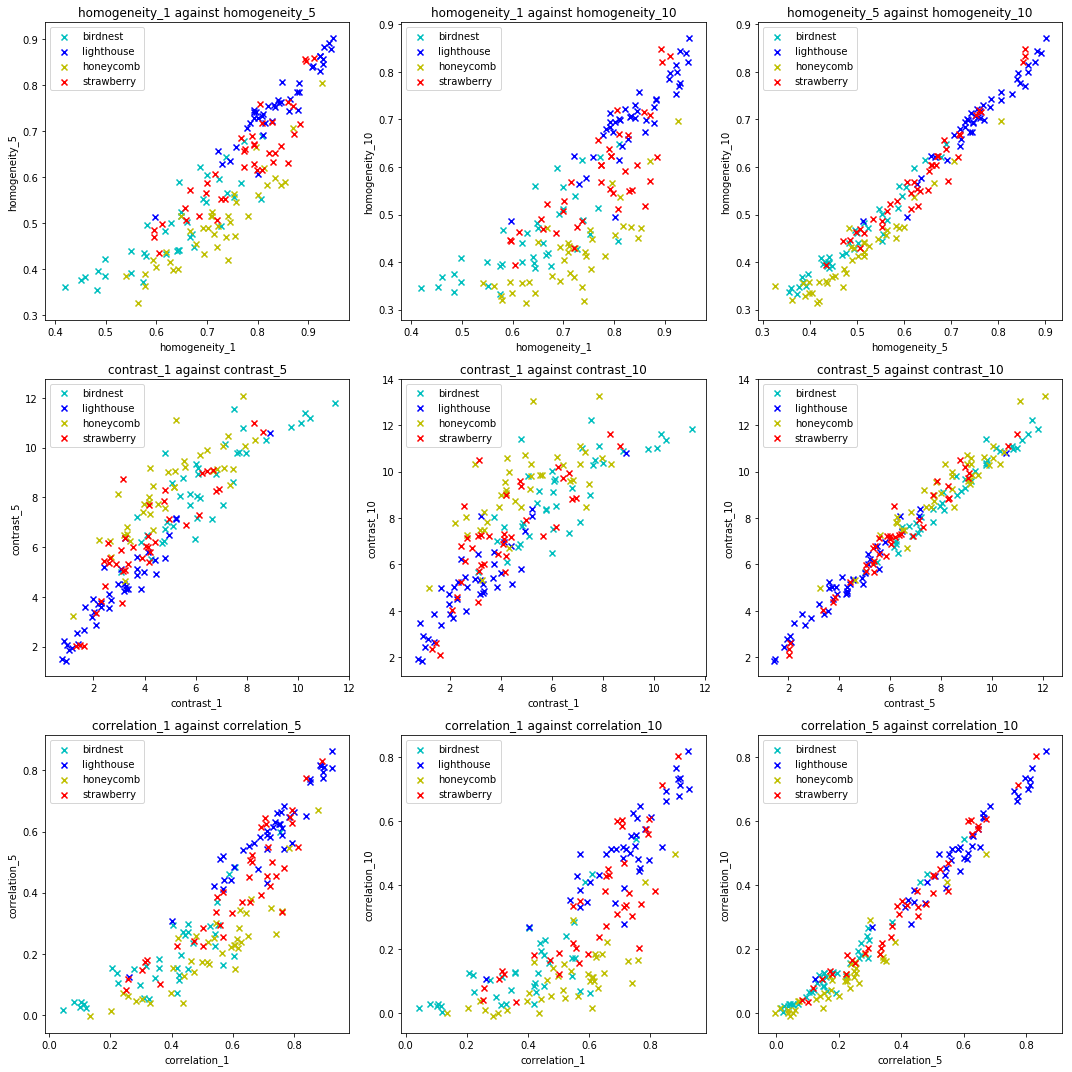

In [37]:
X = X_glcm2
# Set figure size (width, height)
fig, axes = plt.subplots(3, 3,figsize=(15, 15))
# homogeneity_1 against homogeneity_5
axes[0,0].scatter(X[ind_1,0],X[ind_1,1], c='c', marker ='x', label='birdnest')
axes[0,0].scatter(X[ind_2,0],X[ind_2,1], c='b', marker ='x', label='lighthouse')
axes[0,0].scatter(X[ind_3,0],X[ind_3,1], c='y', marker ='x', label='honeycomb')
axes[0,0].scatter(X[ind_4,0],X[ind_4,1], c='r', marker ='x', label='strawberry')
axes[0,0].set_xlabel('homogeneity_1')
axes[0,0].set_ylabel('homogeneity_5')
axes[0,0].legend()
axes[0,0].set_title('homogeneity_1 against homogeneity_5')

# contrast_1 against contrast_10
axes[0,1].scatter(X[ind_1,0],X[ind_1,2], c='c', marker ='x', label='birdnest')
axes[0,1].scatter(X[ind_2,0],X[ind_2,2], c='b', marker ='x', label='lighthouse')
axes[0,1].scatter(X[ind_3,0],X[ind_3,2], c='y', marker ='x', label='honeycomb')
axes[0,1].scatter(X[ind_4,0],X[ind_4,2], c='r', marker ='x', label='strawberry')
axes[0,1].set_xlabel('homogeneity_1')
axes[0,1].set_ylabel('homogeneity_10')
axes[0,1].legend()
axes[0,1].set_title('homogeneity_1 against homogeneity_10')
                  
# homogeneity_5 against homogeneity_10
axes[0,2].scatter(X[ind_1,1],X[ind_1,2], c='c', marker ='x', label='birdnest')
axes[0,2].scatter(X[ind_2,1],X[ind_2,2], c='b', marker ='x', label='lighthouse')
axes[0,2].scatter(X[ind_3,1],X[ind_3,2], c='y', marker ='x', label='honeycomb')
axes[0,2].scatter(X[ind_4,1],X[ind_4,2], c='r', marker ='x', label='strawberry')
axes[0,2].set_xlabel('homogeneity_5')
axes[0,2].set_ylabel('homogeneity_10')
axes[0,2].legend()
axes[0,2].set_title('homogeneity_5 against homogeneity_10')

# contrast_1 against contrast_5
axes[1,0].scatter(X[ind_1,3],X[ind_1,4], c='c', marker ='x', label='birdnest')
axes[1,0].scatter(X[ind_2,3],X[ind_2,4], c='b', marker ='x', label='lighthouse')
axes[1,0].scatter(X[ind_3,3],X[ind_3,4], c='y', marker ='x', label='honeycomb')
axes[1,0].scatter(X[ind_4,3],X[ind_4,4], c='r', marker ='x', label='strawberry')
axes[1,0].set_xlabel('contrast_1')
axes[1,0].set_ylabel('contrast_5')
axes[1,0].legend()
axes[1,0].set_title('contrast_1 against contrast_5')

# contrast_1 against contrast_10
axes[1,1].scatter(X[ind_1,3],X[ind_1,5], c='c', marker ='x', label='birdnest')
axes[1,1].scatter(X[ind_2,3],X[ind_2,5], c='b', marker ='x', label='lighthouse')
axes[1,1].scatter(X[ind_3,3],X[ind_3,5], c='y', marker ='x', label='honeycomb')
axes[1,1].scatter(X[ind_4,3],X[ind_4,5], c='r', marker ='x', label='strawberry')
axes[1,1].set_xlabel('contrast_1')
axes[1,1].set_ylabel('contrast_10')
axes[1,1].legend()
axes[1,1].set_title('contrast_1 against contrast_10')
                  
# contrast_5 against contrast_10
axes[1,2].scatter(X[ind_1,4],X[ind_1,5], c='c', marker ='x', label='birdnest')
axes[1,2].scatter(X[ind_2,4],X[ind_2,5], c='b', marker ='x', label='lighthouse')
axes[1,2].scatter(X[ind_3,4],X[ind_3,5], c='y', marker ='x', label='honeycomb')
axes[1,2].scatter(X[ind_4,4],X[ind_4,5], c='r', marker ='x', label='strawberry')
axes[1,2].set_xlabel('contrast_5')
axes[1,2].set_ylabel('contrast_10')
axes[1,2].legend()
axes[1,2].set_title('contrast_5 against contrast_10')

# correlation_1 against correlation_5
axes[2,0].scatter(X[ind_1,6],X[ind_1,7], c='c', marker ='x', label='birdnest')
axes[2,0].scatter(X[ind_2,6],X[ind_2,7], c='b', marker ='x', label='lighthouse')
axes[2,0].scatter(X[ind_3,6],X[ind_3,7], c='y', marker ='x', label='honeycomb')
axes[2,0].scatter(X[ind_4,6],X[ind_4,7], c='r', marker ='x', label='strawberry')
axes[2,0].set_xlabel('correlation_1')
axes[2,0].set_ylabel('correlation_5')
axes[2,0].legend()
axes[2,0].set_title('correlation_1 against correlation_5')

# correlation_1 against correlation_10
axes[2,1].scatter(X[ind_1,6],X[ind_1,8], c='c', marker ='x', label='birdnest')
axes[2,1].scatter(X[ind_2,6],X[ind_2,8], c='b', marker ='x', label='lighthouse')
axes[2,1].scatter(X[ind_3,6],X[ind_3,8], c='y', marker ='x', label='honeycomb')
axes[2,1].scatter(X[ind_4,6],X[ind_4,8], c='r', marker ='x', label='strawberry')
axes[2,1].set_xlabel('correlation_1')
axes[2,1].set_ylabel('correlation_10')
axes[2,1].legend()
axes[2,1].set_title('correlation_1 against correlation_10')
                  
# correlation_5 against correlation_10
axes[2,2].scatter(X[ind_1,7],X[ind_1,8], c='c', marker ='x', label='birdnest')
axes[2,2].scatter(X[ind_2,7],X[ind_2,8], c='b', marker ='x', label='lighthouse')
axes[2,2].scatter(X[ind_3,7],X[ind_3,8], c='y', marker ='x', label='honeycomb')
axes[2,2].scatter(X[ind_4,7],X[ind_4,8], c='r', marker ='x', label='strawberry')
axes[2,2].set_xlabel('correlation_5')
axes[2,2].set_ylabel('correlation_10')
axes[2,2].legend()
axes[2,2].set_title('correlation_5 against correlation_10')

plt.tight_layout()

plt.show()

Here I will keep features with distances 1 and 10. As we can see, the strawberries are the most difficult class to separate from the other classes. 

In [38]:
# function that calculates final 12 features from GLCM: 
def gray3(image):
    glcm = greycomatrix(image, [1,10], [0,90], symmetric=True, normed=True)
    homogeneity = greycoprops(glcm, 'homogeneity')
    contrast = greycoprops(glcm, 'contrast')
    correlation = greycoprops(glcm, 'correlation')
    x=[homogeneity, contrast, correlation]
    return np.array(x).reshape(12)

In [39]:
# creating final 12 features from GLCM:
X_glcm3 = np.zeros((159,12),dtype=np.float64)
for i in range(159):
    X_glcm3[i] = gray3(X_gray_8[i])

In [40]:
# checking:
X_glcm_df = pd.DataFrame(data = X_glcm3, columns = ['homogeneity_1_0', 'homogeneity_1_90','homogeneity_10_0',  'homogeneity_10_90' ,          
                                                   'contrast_1_0','contrast_1_90', 'contrast_10_0', 'contrast_10_90',
                                                    'correlation_1_0', 'correlation_1_90','correlation_10_0', 'correlation_10_90'])

X_glcm_df.describe()

homogeneity_1_0  homogeneity_1_90  homogeneity_10_0  homogeneity_10_90  \
count       159.000000        159.000000        159.000000         159.000000   
mean          0.742064          0.733275          0.541356           0.521857   
std           0.116612          0.117962          0.147187           0.134734   
min           0.419979          0.424793          0.314153           0.298629   
25%           0.660019          0.655265          0.420223           0.405741   
50%           0.753498          0.735476          0.511149           0.496244   
75%           0.827942          0.821948          0.668795           0.626029   
max           0.947955          0.953247          0.870895           0.841875   

       contrast_1_0  contrast_1_90  contrast_10_0  contrast_10_90  \
count    159.000000     159.000000     159.000000      159.000000   
mean       4.591107       4.754361       7.607285        7.974605   
std        2.210758       2.263203       2.553709        2.352929   
min        0.756678       0.818930       1.842816        2.192858   
25%        3.090245       3.144398       5.682149        6.128460   
50%        4.217570       4.377313       7.629678        8.012945   
75%        6.069526       6.285000       9.672144        9.760245   
max       11.463122      11.355842      13.272333       13.501950   

       correlation_1_0  correlation_1_90  correlation_10_0  correlation_10_90  
count       159.000000        159.000000        159.000000         159.000000  
mean          0.562464          0.547942          0.278083           0.243675  
std           0.204069          0.204803          0.220975           0.195912  
min           0.043736          0.011210         -0.009142          -0.003863  
25%           0.424552          0.413054          0.100248           0.078635  
50%           0.587929          0.562395          0.201603           0.188894  
75%           0.721037          0.714046          0.449916           0.405307  
max           0.925924          0.910619          0.818381           0.699876

In [41]:
# z-score standardization:
X_glcm = zscore(X_glcm3, axis=0)

### 4.6 Final 18 features
Now I have 6 features of color images and 12 features derived from GLCM. 

In [72]:
# Final 18 features in one featurematrix X
X = np.concatenate((X_c, X_glcm), axis = 1)
# save features on the file
np.save('X.npy', X)

X_df = pd.DataFrame(data = X, columns = ['average red', 'average green', 'average blue', 
                                        'variance red', 'variance green', 'varriance blue', 
                                        'homogeneity_1_0', 'homogeneity_1_90','homogeneity_10_0',  'homogeneity_10_90' ,          
                                                   'contrast_1_0','contrast_1_90', 'contrast_10_0', 'contrast_10_90',
                                                    'correlation_1_0', 'correlation_1_90','correlation_10_0', 'correlation_10_90'])

X_df.describe()

average red  average green  average blue  variance red  \
count  1.590000e+02   1.590000e+02  1.590000e+02  1.590000e+02   
mean   3.575058e-16   1.977454e-15  4.245381e-16 -4.915704e-16   
std    1.003160e+00   1.003160e+00  1.003160e+00  1.003160e+00   
min   -2.773618e+00  -2.476014e+00 -1.824331e+00 -1.878517e+00   
25%   -6.227444e-01  -6.843962e-01 -7.437959e-01 -6.973662e-01   
50%   -1.091571e-01  -2.836499e-02 -1.287355e-01 -5.660213e-02   
75%    6.899455e-01   6.895966e-01  8.492672e-01  5.701096e-01   
max    2.731516e+00   2.584408e+00  2.608320e+00  3.642928e+00   

       variance green  varriance blue  homogeneity_1_0  homogeneity_1_90  \
count    1.590000e+02    1.590000e+02     1.590000e+02      1.590000e+02   
mean    -6.479792e-16   -3.924185e-16     3.541542e-15     -1.128378e-15   
std      1.003160e+00    1.003160e+00     1.003160e+00      1.003160e+00   
min     -1.926112e+00   -1.653462e+00    -2.770755e+00     -2.623353e+00   
25%     -7.022230e-01   -6.820546e-01    -7.058023e-01     -6.633987e-01   
50%     -1.758805e-01   -1.477008e-01     9.835902e-02      1.871770e-02   
75%      5.391625e-01    6.545324e-01     7.387735e-01      7.540826e-01   
max      4.033695e+00    3.150186e+00     1.771189e+00      1.870666e+00   

       homogeneity_10_0  homogeneity_10_90  contrast_1_0  contrast_1_90  \
count      1.590000e+02       1.590000e+02  1.590000e+02   1.590000e+02   
mean       1.552916e-15      -2.469024e-15 -6.591513e-16  -4.357102e-16   
std        1.003160e+00       1.003160e+00  1.003160e+00   1.003160e+00   
min       -1.548507e+00      -1.662034e+00 -1.739921e+00  -1.744371e+00   
25%       -8.255849e-01      -8.645394e-01 -6.810348e-01  -7.136124e-01   
50%       -2.058779e-01      -1.906972e-01 -1.694971e-01  -1.671256e-01   
75%        8.685640e-01       7.756092e-01  6.708516e-01   6.784521e-01   
max        2.245983e+00       2.382679e+00  3.118264e+00   2.926091e+00   

       contrast_10_0  contrast_10_90  correlation_1_0  correlation_1_90  \
count   1.590000e+02    1.590000e+02     1.590000e+02      1.590000e+02   
mean   -8.937644e-17    1.228926e-15     1.117206e-15     -2.178551e-15   
std     1.003160e+00    1.003160e+00     1.003160e+00      1.003160e+00   
min    -2.264425e+00   -2.465020e+00    -2.549949e+00     -2.629001e+00   
25%    -7.562408e-01   -7.870951e-01    -6.779427e-01     -6.607027e-01   
50%     8.796454e-03    1.634581e-02     1.251818e-01      7.079339e-02   
75%     8.111272e-01    7.612989e-01     7.795139e-01      8.136071e-01   
max     2.225370e+00    2.356556e+00     1.786691e+00      1.776458e+00   

       correlation_10_0  correlation_10_90  
count      1.590000e+02       1.590000e+02  
mean       2.904734e-16      -5.697748e-16  
std        1.003160e+00       1.003160e+00  
min       -1.303917e+00      -1.267513e+00  
25%       -8.073185e-01      -8.450814e-01  
50%       -3.471972e-01      -2.805042e-01  
75%        7.800687e-01       8.276333e-01  
max        2.452791e+00       2.335966e+00

## 5. Illustrations of the feature relationships

### 5.1 PCA
I calculate PCA and then plot the classes against two first principal components of
1. all 18 features
2. RGB mean and variance
3. GLCM 12 features

In [11]:
m = X.shape[0]
# 1. all 18 features
# Compute covariance matrix:
C = X.T@X/(m-1)
# Eigendecompose covariance matrix:
evals, evecs = np.linalg.eigh(C)
# sort eigenvalues in decreasing order
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
#pick eigenvectors corresponding to 2 largest eigenvalues
M = evecs[:,:2].T
# Project data:
X_pca = (M@X.T).T

In [12]:
# 2. RGB mean and variance
X_c = X[:,0:6]
# Compute covariance matrix:
C = X_c.T@X_c/(m-1)
# Eigendecompose covariance matrix:
evals, evecs = np.linalg.eigh(C)
# sort eigenvalues in decreasing order
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
#pick eigenvectors corresponding to 2 largest eigenvalues
M = evecs[:,:2].T
# Project data:
X_pca_2 = (M@X_c.T).T

In [18]:
# 3. GLCM 12 features
X_glcm = X[:,6:18]
# Compute covariance matrix:
C = X_glcm.T@X_glcm/(m-1)
# Eigendecompose covariance matrix:
evals, evecs = np.linalg.eigh(C)
# sort eigenvalues in decreasing order
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
#pick eigenvectors corresponding to 2 largest eigenvalues
M = evecs[:,:2].T
# Project data:
X_pca_3 = (M@X_glcm.T).T

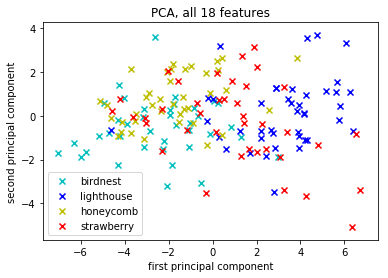

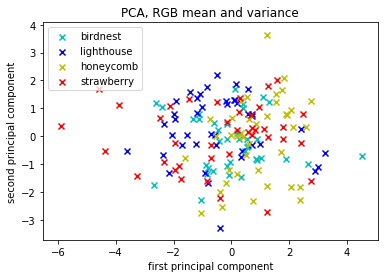

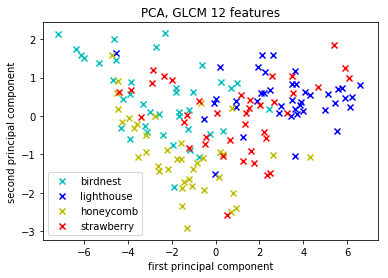

In [20]:
ind_1 = np.where(y == 0)
ind_2 = np.where(y == 1)
ind_3 = np.where(y == 2)
ind_4 = np.where(y == 3)

birdnests=np.array(X_pca[ind_1])
lighthouses=np.array(X_pca[ind_2])
honeycombs=np.array(X_pca[ind_3])
straberries=np.array(X_pca[ind_4])

plt.scatter(birdnests[:,0], birdnests[:,1], c='c', marker ='x', label='birdnest')
plt.scatter(lighthouses[:,0], lighthouses[:,1], c='b', marker ='x', label='lighthouse')
plt.scatter(honeycombs[:,0], honeycombs[:,1], c='y', marker ='x', label='honeycomb')
plt.scatter(straberries[:,0], straberries[:,1], c='r', marker ='x', label='strawberry')
plt.legend()
plt.title("PCA, all 18 features")
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.show()

birdnests=np.array(X_pca_2[ind_1])
lighthouses=np.array(X_pca_2[ind_2])
honeycombs=np.array(X_pca_2[ind_3])
straberries=np.array(X_pca_2[ind_4])

plt.scatter(birdnests[:,0], birdnests[:,1], c='c', marker ='x', label='birdnest')
plt.scatter(lighthouses[:,0], lighthouses[:,1], c='b', marker ='x', label='lighthouse')
plt.scatter(honeycombs[:,0], honeycombs[:,1], c='y', marker ='x', label='honeycomb')
plt.scatter(straberries[:,0], straberries[:,1], c='r', marker ='x', label='strawberry')
plt.legend()
plt.title("PCA, RGB mean and variance")
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.show()

birdnests=np.array(X_pca_3[ind_1])
lighthouses=np.array(X_pca_3[ind_2])
honeycombs=np.array(X_pca_3[ind_3])
straberries=np.array(X_pca_3[ind_4])

plt.scatter(birdnests[:,0], birdnests[:,1], c='c', marker ='x', label='birdnest')
plt.scatter(lighthouses[:,0], lighthouses[:,1], c='b', marker ='x', label='lighthouse')
plt.scatter(honeycombs[:,0], honeycombs[:,1], c='y', marker ='x', label='honeycomb')
plt.scatter(straberries[:,0], straberries[:,1], c='r', marker ='x', label='strawberry')
plt.legend()
plt.title("PCA, GLCM 12 features")
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.show()



Features derived from GLCM seems to be much better features than the features based on colors. I want to see, how the PCA would perform without strawberries.

In [21]:
Xns = X[0:120]
m = Xns.shape[0]
# 1. all 18 features without strawberries
# Compute covariance matrix:
C = Xns.T@Xns/(m-1)
# Eigendecompose covariance matrix:
evals, evecs = np.linalg.eigh(C)
# sort eigenvalues in decreasing order
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
#pick eigenvectors corresponding to 2 largest eigenvalues
M = evecs[:,:2].T
# Project data:
X_pca_ns = (M@Xns.T).T

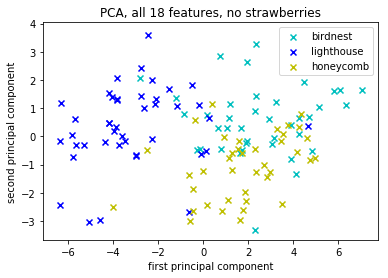

In [22]:
ind_1 = np.where(y == 0)
ind_2 = np.where(y == 1)
ind_3 = np.where(y == 2)
ind_4 = np.where(y == 3)

birdnests=np.array(X_pca_ns[ind_1])
lighthouses=np.array(X_pca_ns[ind_2])
honeycombs=np.array(X_pca_ns[ind_3])
#straberries=np.array(X_pca[ind_4])

plt.scatter(birdnests[:,0], birdnests[:,1], c='c', marker ='x', label='birdnest')
plt.scatter(lighthouses[:,0], lighthouses[:,1], c='b', marker ='x', label='lighthouse')
plt.scatter(honeycombs[:,0], honeycombs[:,1], c='y', marker ='x', label='honeycomb')
#plt.scatter(straberries[:,0], straberries[:,1], c='r', marker ='x', label='strawberry')
plt.legend()
plt.title("PCA, all 18 features, no strawberries")
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.show()


As we can see, PCA could separate birdnests, lighthouses and honeycomps quite well. Straberries make classification much more difficult.

### 5.2 SOM
I used help from here: https://github.com/JustGlowing/minisom and https://glowingpython.blogspot.com/2013/09/self-organizing-maps.html

"MiniSom is a minimalistic and Numpy based implementation of the Self Organizing Maps (SOM). SOM is a type of Artificial Neural Network able to convert complex, nonlinear statistical relationships between high-dimensional data items into simple geometric relationships on a low-dimensional display."

In [49]:
# 1. all 12 features
som = MiniSom(10, 10, 18, sigma=0.3, learning_rate=0.5) # initialization of 10x10 SOM
som.random_weights_init(X)
som.train_random(X, 200) # trains the SOM with 100 iterations

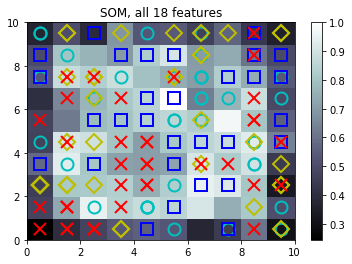

In [50]:
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()
#abels
t = y
# use different colors and markers for each label
markers = ['o','s','D','x']
colors = ['c','b','y', 'r']
for cnt,xx in enumerate(X):
 w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5,w[1]+.5,markers[t[cnt]],markerfacecolor='None',
   markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
#axis([0,som.weights.shape[0],0,som.weights.shape[1]])
plt.title("SOM, all 18 features")
show() # show the figure

In [51]:
# 2. RGB mean and variance
som = MiniSom(10, 10, 6, sigma=0.3, learning_rate=0.5) # initialization of 10x10 SOM
som.random_weights_init(X_c)
som.train_random(X_c, 200) # trains the SOM with 100 iterations

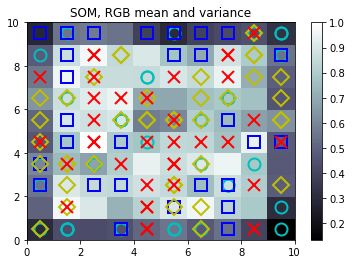

In [52]:
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()
# use different colors and markers for each label
markers = ['o','s','D','x']
colors = ['c','b','y', 'r']
for cnt,xx in enumerate(X_c):
 w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5,w[1]+.5,markers[t[cnt]],markerfacecolor='None',
   markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
plt.title("SOM, RGB mean and variance")
show() # show the figure

In [53]:
# 3. GLCM 12 features
som = MiniSom(10, 10, 12, sigma=0.3, learning_rate=0.5) # initialization of 10x10 SOM
som.random_weights_init(X_glcm)
som.train_random(X_glcm, 200) # trains the SOM with 100 iterations

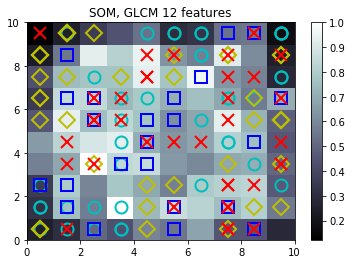

In [54]:
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()
# use different colors and markers for each label
markers = ['o','s','D','x']
colors = ['c','b','y', 'r']
for cnt,xx in enumerate(X_glcm):
 w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5,w[1]+.5,markers[t[cnt]],markerfacecolor='None',
   markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
#axis([0,som.weights.shape[0],0,som.weights.shape[1]])
plt.title("SOM, GLCM 12 features")
show() # show the figure

I want to test also SOM without straberries.

In [55]:
# 1. all 18 features
som = MiniSom(10, 10, 18, sigma=0.3, learning_rate=0.5) # initialization of 10x10 SOM
som.random_weights_init(Xns)
som.train_random(X, 200) # trains the SOM with 100 iterations

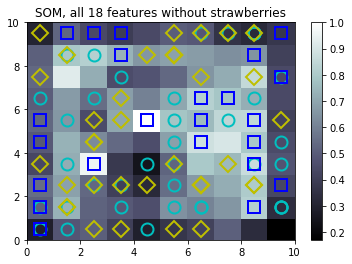

In [56]:
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()
# use different colors and markers for each label
markers = ['o','s','D','x']
colors = ['c','b','y', 'r']
for cnt,xx in enumerate(Xns):
 w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5,w[1]+.5,markers[t[cnt]],markerfacecolor='None',
   markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
#axis([0,som.weights.shape[0],0,som.weights.shape[1]])
plt.title("SOM, all 18 features without strawberries")
show() # show the figure

Also SOM could separate classes much better without straberries. But there is still quite a lot of overlapping.

## 6. Calculations

### 6.1 K nearest neighbors
I will start with kNN in order to get a baseline for prediction accuracy. I will use nested leave-one-out method to estimate the accuracy of this kNN method.

In [58]:
k_range = range(1,21)
image_range = range(X.shape[0])

loo = LeaveOneOut()

k_best = []
y_preds = np.zeros(X.shape[0])

#outer loop:
for image in image_range:
    test_index = [image]
    train_index = np.delete(image_range, image)
    
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    accuracy = []
    #inner loop: kNN
    for k in k_range:
        checkfit = []
        
        for subtrain_index, validation_index in loo.split(X_train):
            X_subtrain = X[subtrain_index]
            y_subtrain = y[subtrain_index]
            X_validation = X[validation_index]
            y_validation = y[validation_index]
            
            knn = KNeighborsClassifier(n_neighbors = k)
            knn.fit(X_subtrain, y_subtrain)
            y_pred = knn.predict(X_validation)
            # save accuracy
            checkfit.append(accuracy_score(y_validation, y_pred))
         #save average accuracy for each inner loop   
        accuracy.append(np.mean(checkfit))
    
    #find best k
    k_best.append(k_range[accuracy.index(max(accuracy))])
    # train with best k
    knn = KNeighborsClassifier(n_neighbors = k_best[image])
    knn.fit(X_train, y_train)
    # save the predicted class
    y_preds[image]= knn.predict(X_test)
              

In [59]:
print(confusion_matrix(y_preds, y))
acc = np.sum(np.diagonal(confusion_matrix(y_preds,y))/X.shape[0])
print('The estimated accuracy for the method is:', acc)

[[33  5  8  5]
 [ 3 34  0  4]
 [ 3  0 26  2]
 [ 0  3  5 28]]
The estimated accuracy for the method is: 0.761006289308176


As expected, the strawberries cause most confusion. Let's look again what the accuracy would be without strawberries. 

In [44]:
Xns = X[0:120]
yns = y[0:120]

k_range = range(1,21)
image_range = range(Xns.shape[0])

loo = LeaveOneOut()

k_best = []
y_preds = np.zeros(Xns.shape[0])

#outer loop:
for image in image_range:
    test_index = [image]
    train_index = np.delete(image_range, image)
    
    X_train = Xns[train_index]
    y_train = yns[train_index]
    X_test = Xns[test_index]
    y_test = yns[test_index]
    
    accuracy = []
    #inner loop: kNN
    for k in k_range:
        checkfit = []
        
        for subtrain_index, validation_index in loo.split(X_train):
            X_subtrain = Xns[subtrain_index]
            y_subtrain = yns[subtrain_index]
            X_validation = Xns[validation_index]
            y_validation = yns[validation_index]
            
            knn = KNeighborsClassifier(n_neighbors = k)
            knn.fit(X_subtrain, y_subtrain)
            y_pred = knn.predict(X_validation)
            # save accuracy
            checkfit.append(accuracy_score(y_validation, y_pred))
         #save average accuracy for each inner loop   
        accuracy.append(np.mean(checkfit))
    
    #find best k
    k_best.append(k_range[accuracy.index(max(accuracy))])
    # train with best k
    knn = KNeighborsClassifier(n_neighbors = k_best[image])
    knn.fit(X_train, y_train)
    # save the predicted class
    y_preds[image]= knn.predict(X_test)
              

In [45]:
print(confusion_matrix(y_preds, yns))
acc = np.sum(np.diagonal(confusion_matrix(y_preds,yns))/Xns.shape[0])
print('The estimated accuracy for the method (without strawberries) is:', acc)

[[35  5 12]
 [ 2 37  2]
 [ 2  0 25]]
The estimated accuracy for the method (without strawberries) is: 0.8083333333333335


Without strawberries the accuracy would be much better (0,81). In this case it is most difficult to distinguish between bird nests and honeycombs.

In [48]:
wrong_ind= []
for i in range(len(yns)):
    if (yns[i] != y_preds[i]):
        wrong_ind.append(i)

Color images: All 23 wrongly classified images:


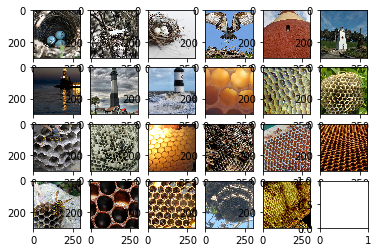

In [49]:
io.imshow_collection(X_color[wrong_ind])
print('Color images: All 23 wrongly classified images:')

8-level gray images: All 23 wrongly classified images:


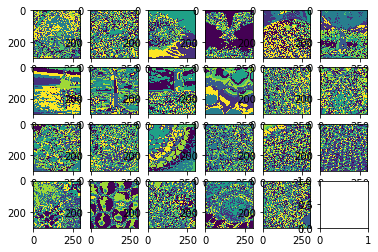

In [51]:
io.imshow_collection(X_gray_8[wrong_ind])
print('8-level gray images: All 23 wrongly classified images:')

### 6.2 Regularized linear model with ridge regression
When doing classification as regression, the problem has to be devided to subproblems, where a classifier is trained for each class against other classes. At prediction phase the class with highest predicted value is chosen. 

Subproblems:

* subproblem 1: classify images into "bird nests"(y=1) vs. "no bird nests"(y=-1)
* subproblem 2: classify images into "lighthouses"(y=1) vs. "no lighthouses"(y=-1)
* subproblem 3: classify images into "honeycombs"(y=1) vs. "no honeycombs"(y=-1)
* subproblem 4: classify images into "strawberries"(y=1) vs. "no strawberries"(y=-1)


In [35]:
# First I will create these four new y:s.

# subproblem 1: classify images into "bird nests"(y=1) vs. "no bird nests"(y=-1)
y_b = np.zeros((len(y),1))
for i in list(ind_1):
    y_b[i] = 1
for i in list(ind_2):
    y_b[i] = -1
for i in list(ind_3):
    y_b[i] = -1
for i in list(ind_4):
    y_b[i] = -1

# subproblem 2: classify images into "lighthouses"(y=1) vs. "no lighthouses"(y=-1)
y_l = np.zeros((len(y),1))
for i in list(ind_1):
    y_l[i] = -1
for i in list(ind_2):
    y_l[i] = 1
for i in list(ind_3):
    y_l[i] = -1
for i in list(ind_4):
    y_l[i] = -1
    
# subproblem 3: classify images into "honeycombs"(y=1) vs. "no honeycombs"(y=-1)
y_h = np.zeros((len(y),1))
for i in list(ind_1):
    y_h[i] = -1
for i in list(ind_2):
    y_h[i] = -1
for i in list(ind_3):
    y_h[i] = 1
for i in list(ind_4):
    y_h[i] = -1

# 4: classify images into "strawberries"(y=1) vs. "no strawberries"(y=-1)
y_s = np.zeros((len(y),1))
for i in list(ind_1):
    y_s[i] = -1
for i in list(ind_2):
    y_s[i] = -1
for i in list(ind_3):
    y_s[i] = -1
for i in list(ind_4):
    y_s[i] = 1

y_all = np.concatenate((y_b, y_l, y_h, y_s), axis = 1)

In [75]:
# ridge regression
y_reg = np.zeros((len(y),4))  # regression results

loo = LeaveOneOut()
clf = Ridge(alpha=1.0)

for train_index, test_index in loo.split(X):
    X_train=X[train_index]
    y_train=y_all[train_index]
    X_test=X[test_index]
    y_test=y_all[test_index]
    
    for i in range(4):
        clf.fit(X_train, y_train[:, i])
        y_reg[test_index,i]=clf.predict(X_test)




In [76]:
# predictions
y_pred=np.zeros(len(y))  
for i in range (len(y)):
    if y_reg[i,0]>= y_reg[i,1]and y_reg[i,0]>= y_reg[i,2] and y_reg[i,0]>= y_reg[i,3]:
        y_pred[i]=0        
    elif y_reg[i,1]>= y_reg[i,0]and y_reg[i,1]>= y_reg[i,2] and y_reg[i,1]>= y_reg[i,3]:
        y_pred[i]=1
    elif y_reg[i,2]>= y_reg[i,0]and y_reg[i,2]>= y_reg[i,1] and y_reg[i,2]>= y_reg[i,3]:
        y_pred[i]=2
    elif y_reg[i,3]>= y_reg[i,0]and y_reg[i,3]>= y_reg[i,1] and y_reg[i,3]>= y_reg[i,2]:
        y_pred[i]=3


In [77]:
print(confusion_matrix(y_pred, y))
acc = np.sum(np.diagonal(confusion_matrix(y_pred,y))/X.shape[0])
print('The estimated accuracy for the method is:', acc)

[[28  1  8  0]
 [ 5 39  1  7]
 [ 5  1 28  5]
 [ 1  1  2 27]]
The estimated accuracy for the method is: 0.7672955974842767


The prediction performance of regularized linear model with ridge regression seem to be almost the same (0.77) than the prediction performance with kNN (0.76).

I tried to use different values for alpha, but it didn't affect to the results. Therefore I used simple leave-one-out cross validation with a default value of alpha = 1.0.

Let's look again what the accuracy would be without strawberries. 

In [78]:
# ridge regression without strawberries
y_reg = np.zeros((120,4))  # regression results
y_allns = y_all[0:120]
yns = y[0:120]

loo = LeaveOneOut()
clf = Ridge(alpha=1.0)

for train_index, test_index in loo.split(Xns):
    X_train=Xns[train_index]
    y_train=y_allns[train_index]
    X_test=Xns[test_index]
    y_test=y_allns[test_index]
    
    for i in range(4):
        clf.fit(X_train, y_train[:, i])
        y_reg[test_index,i]=clf.predict(X_test)



In [79]:
# predictions
y_pred=np.zeros(len(yns))  
for i in range(len(yns)):
    if y_reg[i,0]>= y_reg[i,1]and y_reg[i,0]>= y_reg[i,2] and y_reg[i,0]>= y_reg[i,3]:
        y_pred[i]=0        
    elif y_reg[i,1]>= y_reg[i,0]and y_reg[i,1]>= y_reg[i,2] and y_reg[i,1]>= y_reg[i,3]:
        y_pred[i]=1
    elif y_reg[i,2]>= y_reg[i,0]and y_reg[i,2]>= y_reg[i,1] and y_reg[i,2]>= y_reg[i,3]:
        y_pred[i]=2
    elif y_reg[i,3]>= y_reg[i,0]and y_reg[i,3]>= y_reg[i,1] and y_reg[i,3]>= y_reg[i,2]:
        y_pred[i]=3

In [80]:
print(confusion_matrix(y_pred, yns))
acc = np.sum(np.diagonal(confusion_matrix(y_pred,yns))/Xns.shape[0])
print('The estimated accuracy for the method is:', acc)

[[27  1  7]
 [ 5 40  1]
 [ 7  1 31]]
The estimated accuracy for the method is: 0.8166666666666667


The prediction accuracy 0.82 is better without strawberries (with strawberries 0.77), and almost the same than with kNN (0.81).

The hardest part here, seems to be distinguishing between bird nests and honeycombs. Let's look at some wrongly classified images of bird nests and honey combs.


In [81]:
wrong_ind= []
for i in range(len(yns)):
    if (yns[i]==0 and y_pred[i]==2) or (yns[i]==2 and y_pred[i]==0):
        wrong_ind.append(i)
    

Color images: The 7 bird nests that are classified as honeycombs and the 7 honeycombs that are classified as bird nests:


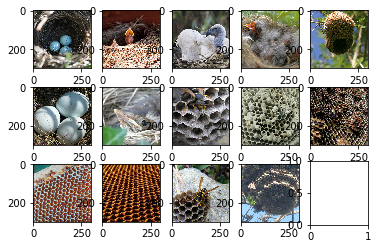

In [82]:
io.imshow_collection(X_color[wrong_ind])
print('Color images: The 7 bird nests that are classified as honeycombs and the 7 honeycombs that are classified as bird nests:')

8-level gray images: The 7 bird nests that are classified as honeycombs and the 7 honeycombs that are classified as bird nests:


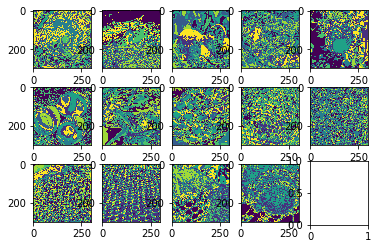

In [31]:
io.imshow_collection(X_gray_8[wrong_ind])
print('8-level gray images: The 7 bird nests that are classified as honeycombs and the 7 honeycombs that are classified as bird nests:')

In [36]:
wrong_ind= []
for i in range(len(yns)):
    if (yns[i] != y_pred[i]):
        wrong_ind.append(i)

Color images: All 22 wrongly classified images:


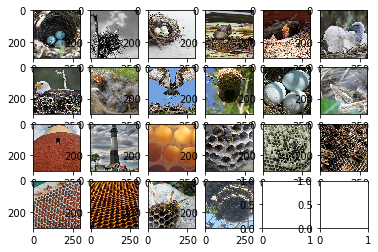

In [37]:
io.imshow_collection(X_color[wrong_ind])
print('Color images: All 22 wrongly classified images:')

8-level gray images: All 22 wrongly classified images:


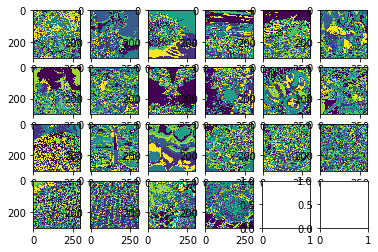

In [39]:
io.imshow_collection(X_gray_8[wrong_ind])
print('8-level gray images: All 22 wrongly classified images:')

When looking at the 8-level gray images, it is easy to understand, that it is very difficult to classify these images correctly.

### 6.3 Multi-layer perceptron with 1 hidden layer and early stop committee

Next I will use multi-layer perceptron with 1 hidden layer and early stop committee. As a output function I will use Softmax. I will use nested stratified K-Fold (k=10) cross-validation, where I have as a hyperparameter a number of nodes (8,16 or 32 nodes) in the hidden layer.

With early stopping I used help from here: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [442]:
labels = to_categorical(y)

In [450]:
# memory clean-up: destroys the current TF graph and creates a new one.
from keras import backend as K
K.clear_session()

In [444]:
def create_model(nodes):
    model = models.Sequential()
    model.add(layers.Dense(nodes, activation='relu', input_shape=(18,)))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [445]:
nodes = [8,16,32]
image_range = range(X.shape[0])

skf = StratifiedKFold(n_splits=10)

n_best = []
y_preds = np.zeros(X.shape[0])

n_best_index = 0

#outer loop:
for train_index, test_index in skf.split(X,y):
    X_train = X[train_index]
    y_train = labels[train_index]
    X_test = X[test_index]
    y_test = labels[test_index]
    
    accuracy = []
    #inner loop: 
    for n in nodes:
        acc = []
        
        for subtrain_index, validation_index in skf.split(X_train,y[train_index]):
            X_subtrain = X[subtrain_index]
            y_subtrain = labels[subtrain_index]
            X_val = X[validation_index]
            y_val = labels[validation_index]
            
            # create model
            model = create_model(n)
            # early stopping
            es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
            # fit
            history = model.fit(X_subtrain, y_subtrain, epochs= 100, batch_size=150, validation_data=(X_val, y_val), verbose = 0, callbacks=[es])
            #validation
            _, val_acc = model.evaluate(X_val, y_val, verbose=0)
            acc.append(val_acc) # val_acc = 0 (false) or 1 (true)
            

        #save average accuracy for each inner loop   
        accuracy.append(np.mean(acc))
        # just to see how the cross-validation progress
        print(n, 'ready')
    
    #find best n
    n_best.append(nodes[accuracy.index(max(accuracy))])
    # train with best n
    # create model
    model = create_model(n_best[n_best_index])
    # early stopping
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    # fit
    model.fit(X_train, y_train, epochs= 100, batch_size=20, validation_data=(X_val, y_val), verbose = 0, callbacks=[es])
    # prediction
    y_preds[test_index] = np.argmax(model.predict(X_test), axis = 1)
    n_best_index = n_best_index +1
    
    


8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready
8 ready
16 ready
32 ready


In [446]:
# I want to see, how many nodes was used in each outer loop:
n_best

[32, 32, 32, 16, 32, 32, 32, 32, 32, 32]

In [447]:
print(confusion_matrix(y_preds, y))
acc = np.sum(np.diagonal(confusion_matrix(y_preds,y))/X.shape[0])
print('The estimated accuracy for the method is:', acc)

[[30  3  9  0]
 [ 4 37  0  4]
 [ 5  0 28  7]
 [ 0  2  2 28]]
The estimated accuracy for the method is: 0.7735849056603773


With this model I got the same estimated accuracy than with Ridge regression.

And again, I want to see the results without strawberries. This time I use simple 10-fold cross-validation with 32 number of nodes in the hidden layer.

In [451]:
Xns = X[0:120]
yns = y[0:120]
labels_ns = labels[0:120]

y_preds_ns = np.zeros(Xns.shape[0])

skf = StratifiedKFold(n_splits=10)
        
for train_index, validation_index in skf.split(Xns, yns):
    X_train = Xns[train_index]
    y_train = labels_ns[train_index]
    X_val = Xns[validation_index]
    y_val = labels_ns[validation_index]
            
    # create model
    model = create_model(32)
    # early stopping
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    # fit
    model.fit(X_train, y_train, epochs= 100, batch_size=8, validation_data=(X_val, y_val), verbose = 0, callbacks=[es])
    
    # prediction
    y_preds_ns[validation_index] = np.argmax(model.predict(X_val), axis = 1)

In [452]:
print(confusion_matrix(y_preds_ns, yns))
acc = np.sum(np.diagonal(confusion_matrix(y_preds_ns,yns))/Xns.shape[0])
print('The estimated accuracy for the method (without strawberries) is:', acc)

[[30  3  9]
 [ 4 39  1]
 [ 5  0 29]]
The estimated accuracy for the method (without strawberries) is: 0.8166666666666667


The estimated accuracy is exactly the same than with Ridge regression. Let's see if they are the same pictures than with Ridge regression.

In [459]:
wrong_ind= []
for i in range(len(yns)):
    if (yns[i] != y_preds_ns[i]):
        wrong_ind.append(i)

Color images: All 22 wrongly classified images:


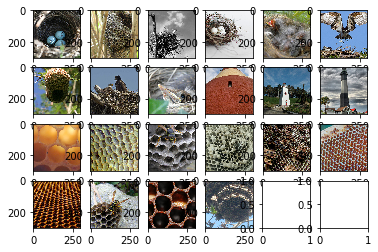

In [460]:
io.imshow_collection(X_color[wrong_ind])
print('Color images: All 22 wrongly classified images:')

8-level gray images: All 22 wrongly classified images:


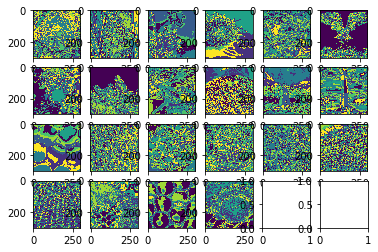

In [461]:
io.imshow_collection(X_gray_8[wrong_ind])
print('8-level gray images: All 22 wrongly classified images:')

The wrongly classified images are not exactly the same with different classifiers. 

I want to see, if I can improve the results by adding one more layer.

In [456]:
def create_model2(nodes1, nodes2):
    model = models.Sequential()
    model.add(layers.Dense(nodes1, activation='relu', input_shape=(18,)))
    model.add(layers.Dense(nodes2, activation='relu', input_shape=(18,)))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [457]:
Xns = X[0:120]
yns = y[0:120]
labels_ns = labels[0:120]

y_preds_ns2 = np.zeros(Xns.shape[0])

skf = StratifiedKFold(n_splits=10)
        
for train_index, validation_index in skf.split(Xns, yns):
    X_train = Xns[train_index]
    y_train = labels_ns[train_index]
    X_val = Xns[validation_index]
    y_val = labels_ns[validation_index]
            
    # create model
    model = create_model2(32,16)
    # early stopping
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    # fit
    model.fit(X_train, y_train, epochs= 100, batch_size=8, validation_data=(X_val, y_val), verbose = 0, callbacks=[es])
    
    # prediction
    y_preds_ns2[validation_index] = np.argmax(model.predict(X_val), axis = 1)

In [458]:
print(confusion_matrix(y_preds_ns2, yns))
acc = np.sum(np.diagonal(confusion_matrix(y_preds_ns2,yns))/Xns.shape[0])
print('The estimated accuracy for the method (without strawberries) is:', acc)

[[28  5  8]
 [ 4 37  1]
 [ 7  0 30]]
The estimated accuracy for the method (without strawberries) is: 0.7916666666666667


Adding one more layer does not seem to help.

## Results and discussion

I got almost the same results with all methods.

kNN: 
* accuracy with all the data: 0.76
* accuracy without strawberries: 0.81

Ridge regression: 
* accuracy with all the data: 0.77
* accuracy without strawberries: 0.82

MLP (with one hidden layer): 
* accuracy with all the data: 0.77
* accuracy without strawberries: 0.82


Even though all the classifiers have alomost the same estimated accuracy, they make mistakes at least partially with different pictures. Therefore it would be interesting to see if better results could be achieved by combining them with ensemble learning. 

I think that one weak step in this process was, that the pictures were crobbed in the most simplest way, by just crobbing an area of 300 x 300 pixels from the center of each image. The results could have been better, if the crobbing had been made case by case. 

The data set was quite little. With more data the results could have been more accurate. Or I could have created augmented data in order to have larger data set.

I did'n use all the possible features that could have been derived from GLCM. But because there might have been high correlation between those features, maybe it would not have helped so much anyway.  And of course a lot of information disappeared by quantization.

Beforehand I thought that it would be very easy to classify the strawberries right. But because of their second order texture measures, it was very difficult. There was also other colors than red in the strawberry pictures, and actually the mean value of redness was just one single feature among 17 others.

It would be interesting to see how well the convolutional network could classify these same pictures.

Altogether, this was an instructive exercise.


